# Génération de légendes pour les images avec CNN-RNN

Dans ce notebook, nous allons implémenter un modèle capable de générer des légendes automatiques pour des images en utilisant une combinaison d'un réseau de neurones convolutif (CNN) pour l'extraction des caractéristiques visuelles et d'un réseau de neurones récurrent (RNN) pour la génération des légendes texte.

Nous utiliserons le dataset MS COCO pour entraîner notre modèle. Ce dataset contient des images annotées avec des descriptions détaillées, ce qui en fait une base de données idéale pour la tâche de captioning (génération de légendes).

# import && path du dataset


In [5]:
import os
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
from pycocotools.coco import COCO
import json
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [9]:
base_dir = os.getcwd()
relative_path = r"..\..\DataSets\Dataset_delivrable_3"
dataset_dir = os.path.normpath(os.path.join(base_dir, relative_path))

c:\Users\steve\Documents\GitHub\DataSciencePictureDesc\DataSets\Dataset_delivrable_3


# Pré-traitement des données

## Pré-traitement des images

Nous allons utiliser un modèle CNN pré-entraîné, tel que ResNet50 ou InceptionV3, pour extraire des caractéristiques visuelles des images. Ce modèle sera chargé avec les poids pré-entraînés sur ImageNet, ce qui nous permet d'utiliser un extracteur de caractéristiques performant sans avoir à l'entraîner à partir de zéro.

In [1]:
# Chargement du modèle ResNet50 pré-entraîné
model_cnn = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Fonction pour extraire les caractéristiques d'une image
def extract_features(img_path, model_cnn):
    img = image.load_img(img_path, target_size=(224, 224))  # Redimensionner l'image
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    
    features = model_cnn.predict(img_data)
    return features


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step


## Pré-traitement des légendes
Les légendes associées aux images doivent être tokenisées pour être traitées par le réseau de neurones. Nous allons aussi appliquer du padding pour normaliser la longueur des séquences textuelles afin de rendre les données compatibles avec notre modèle.

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenization des légendes
def preprocess_text(captions, max_length):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(captions)
    
    # Convertir les légendes en séquences de tokens
    sequences = tokenizer.texts_to_sequences(captions)
    sequences_padded = pad_sequences(sequences, maxlen=max_length, padding='post')
    
    return sequences_padded, tokenizer


## Chargement du dataset MS COCO
Nous devons maintenant charger le dataset MS COCO et appliquer les étapes de pré-traitement aux images et aux légendes. Pour cet exemple, nous allons utiliser un sous-ensemble du dataset pour simplifier le processus.

In [55]:
#path file data set COCO
train_images_dir = os.path.join(dataset_dir, 'train2014/')
val_images_dir = os.path.join(dataset_dir, 'val2014/')
train_annotations_file = os.path.join(dataset_dir, 'annotations/captions_train2014.json')


In [41]:
# Initialisation of COCO object && show structure
coco = COCO(train_annotations_file)
print(dir(coco))

loading annotations into memory...
Done (t=0.31s)
creating index...
index created!
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'annToMask', 'annToRLE', 'anns', 'catToImgs', 'cats', 'createIndex', 'dataset', 'download', 'getAnnIds', 'getCatIds', 'getImgIds', 'imgToAnns', 'imgs', 'info', 'loadAnns', 'loadCats', 'loadImgs', 'loadNumpyAnnotations', 'loadRes', 'showAnns']


In [20]:
# Récupérer toutes les ID d'images
image_ids = coco.getImgIds()

# Charger une image et ses annotations (exemple)
def load_image_and_caption(image_id):
    # Récupérer l'information de l'image
    img_info = coco.loadImgs(image_id)[0]
    img_path = os.path.join(train_images_dir, img_info['file_name'])
    
    # Charger l'image
    img = load_img(img_path, target_size=(224, 224))  # Redimensionner l'image pour ResNet50
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    
    # Récupérer les légendes associées à l'image
    ann_ids = coco.getAnnIds(imgIds=image_id)
    anns = coco.loadAnns(ann_ids)
    captions = [ann['caption'] for ann in anns]
    
    return img, captions

# Exemple d'utilisation
img_id = image_ids[0]
img, captions = load_image_and_caption(img_id)

print(f"Légendes pour l'image {img_id}:")
print(captions)


Légendes pour l'image 57870:
['A restaurant has modern wooden tables and chairs.', 'A long restaurant table with rattan rounded back chairs.', 'a long table with a plant on top of it surrounded with wooden chairs ', 'A long table with a flower arrangement in the middle for meetings', 'A table is adorned with wooden chairs with blue accents.']


# Architecture du modèle

## Architecture CNN-RNN pour le captioning
Nous allons maintenant définir l'architecture du modèle CNN-RNN. La partie CNN extraira des caractéristiques visuelles des images, tandis que la partie RNN générera des légendes sous forme de séquences de mots.

## RNN : Génération de texte avec LSTM
Le modèle RNN est constitué de couches LSTM qui reçoivent la sortie du CNN et génèrent des légendes mot par mot.

In [23]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout, Input, Add
from tensorflow.keras.models import Model

# Définir le modèle d'extraction de caractéristiques CNN
def create_cnn_model():
    resnet = ResNet50(weights="imagenet", include_top=False, pooling="avg")
    for layer in resnet.layers:
        layer.trainable = False
    return resnet

# Définir le modèle RNN pour la génération de légendes
def create_captioning_model(vocab_size, max_length):
    # Partie image (CNN)
    image_input = Input(shape=(2048,))
    image_model = Dropout(0.5)(image_input)
    image_model = Dense(256, activation='relu')(image_model)

    # Partie texte (RNN)
    caption_input = Input(shape=(max_length,))
    caption_model = Embedding(vocab_size, 256)(caption_input)
    caption_model = Dropout(0.5)(caption_model)
    caption_model = LSTM(256)(caption_model)

    # Fusion des deux modèles
    combined = Add()([image_model, caption_model])
    combined = Dense(256, activation='relu')(combined)
    outputs = Dense(vocab_size, activation='softmax')(combined)

    # Création du modèle final
    model = Model(inputs=[image_input, caption_input], outputs=outputs)
    return model

# Créer le modèle
vocab_size = 5000  # Taille du vocabulaire
max_length = 34    # Longueur maximale des légendes
captioning_model = create_captioning_model(vocab_size, max_length)

# Compiler le modèle
captioning_model.compile(loss='categorical_crossentropy', optimizer='adam')
captioning_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 34, 256)   │  1,280,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 34, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 5000)      │  1,285,000 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,680,648 (14.04 MB)

 Trainable params: 3,680,648 (14.04 MB)

 Non-trainable params: 0 (0.00 B)

## Entraînement du modèle

L'entraînement du modèle implique d'optimiser les poids du réseau CNN-RNN pour minimiser la perte de prédiction des légendes. Nous suivrons l'évolution des performances à l'aide de courbes de perte.

In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenisation des légendes
def preprocess_captions(captions, vocab_size, max_length):
    tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
    tokenizer.fit_on_texts(captions)
    sequences = tokenizer.texts_to_sequences(captions)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
    return tokenizer, padded_sequences

# Exemples de légendes (test) pour entraînement
captions = ['A long table with chairs', 'A man riding a bike', 'A cat sitting on a couch']

# Prétraiter les légendes
tokenizer, padded_sequences = preprocess_captions(captions, vocab_size, max_length)
print("Séquences de légendes après prétraitement:")
print(padded_sequences)


Séquences de légendes après prétraitement:
[[ 2  3  4  5  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0]
 [ 2  7  8  2  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0]
 [ 2 10 11 12  2 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0]]


loading annotations into memory...
Done (t=0.36s)
creating index...
index created!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 

c:\Users\steve\Documents\GitHub\DataSciencePictureDesc\data-science\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1288', 'keras_tensor_1290']. Received: the structure of inputs=('*', '*')
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.3933 - loss: 5.2655
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.5350 - loss: 3.2036
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.5420 - loss: 2.9813
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.5652 - loss: 2.7216
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.6083 - loss: 2.4352
Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.6600 - loss: 2.1251
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.6913 - loss: 1.8409
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.7101 - loss: 1.6134
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.7287 - loss: 1.4079
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.7641 - loss: 1.1812


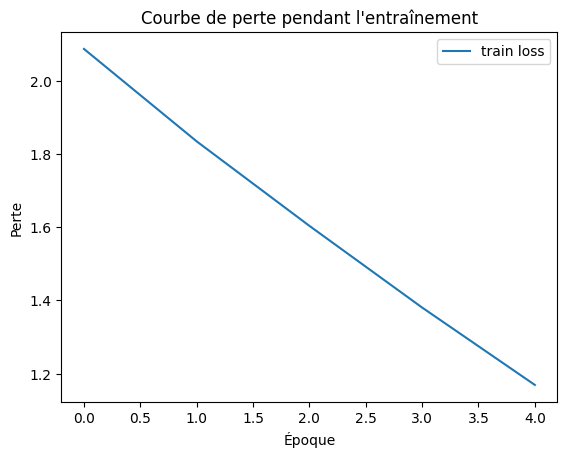

In [35]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Add
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from pycocotools.coco import COCO
import matplotlib.pyplot as plt


# Initialiser l'objet COCO
coco = COCO(train_annotations_file)

# Récupérer toutes les ID d'images
image_ids = coco.getImgIds()

# Charger une image et ses annotations
def load_image_and_caption(image_id):
    img_info = coco.loadImgs(image_id)[0]
    img_path = os.path.join(train_images_dir, img_info['file_name'])
    img = load_img(img_path, target_size=(224, 224))  # Redimensionner l'image pour ResNet50
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.resnet.preprocess_input(img)  # Prétraitement pour ResNet50
    ann_ids = coco.getAnnIds(imgIds=image_id)
    anns = coco.loadAnns(ann_ids)
    captions = [ann['caption'] for ann in anns]
    return img, captions

# Créer le modèle CNN pour l'extraction des caractéristiques (ResNet50)
def create_cnn_model():
    base_model = ResNet50(weights='imagenet')
    model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)  # Dernière couche avant la classification
    return model

# Fonction pour extraire les caractéristiques d'images à partir de ResNet50
def extract_image_features(image_ids, coco, resnet_model):
    features = []
    for img_id in image_ids:
        img, _ = load_image_and_caption(img_id)  # Charger l'image
        img_features = resnet_model.predict(img)  # Extraire les caractéristiques avec ResNet50
        features.append(np.squeeze(img_features))
    return np.array(features)

# Prétraiter les légendes
def preprocess_captions(captions, tokenizer, max_length):
    sequences = tokenizer.texts_to_sequences(captions)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
    return padded_sequences

# Modèle pour la partie RNN (LSTM pour le texte)
def create_captioning_model(vocab_size, max_sequence_length):
    # Entrée des caractéristiques d'image (sortie du CNN)
    image_input = Input(shape=(2048,))

    # Ajouter une couche dense pour transformer les caractéristiques en vecteur de taille fixe
    image_dense = Dense(256, activation='relu')(image_input)

    # Entrée de la légende
    text_input = Input(shape=(max_sequence_length,))
    text_embedding = Embedding(input_dim=vocab_size, output_dim=256, mask_zero=True)(text_input)
    text_lstm = LSTM(256, return_sequences=True)(text_embedding)  # Prédire chaque mot, pas seulement le dernier

    # Ajouter et fusionner les deux parties (image + légende)
    decoder = Add()([image_dense, text_lstm])
    decoder = Dense(vocab_size, activation='softmax')(decoder)

    # Créer le modèle
    model = Model(inputs=[image_input, text_input], outputs=decoder)
    return model

# Exemple de vocabulaire et longueur maximale de séquence
vocab_size = 5000
max_sequence_length = 20

# Créer le modèle CNN-RNN
captioning_model = create_captioning_model(vocab_size, max_sequence_length)

# Compiler le modèle
captioning_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Créer le modèle ResNet50 pour l'extraction des caractéristiques
resnet_model = create_cnn_model()

# Exemple d'extraction d'images et légendes
image_ids_subset = image_ids[:1000]  # On peut limiter à un sous-ensemble pour l'exemple
image_features = extract_image_features(image_ids_subset, coco, resnet_model)

# Traiter les légendes
all_captions = []
for img_id in image_ids_subset:
    _, captions = load_image_and_caption(img_id)
    all_captions.extend(captions)

# Créer le tokenizer à partir de toutes les légendes
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(all_captions)

# Séquences de légendes traitées
sequences = [preprocess_captions([caption], tokenizer, max_sequence_length) for caption in all_captions]

# On prend une légende par image pour l'entraînement (par simplicité)
train_captions = [seq[0] for seq in sequences[:1000]]

# Convertir les légendes en one-hot encoding pour l'entraînement
train_captions_encoded = to_categorical(train_captions, num_classes=vocab_size)

# Entraîner le modèle
captioning_model.fit([image_features, np.array(train_captions)], train_captions_encoded, epochs=5)

# Visualisation des pertes d'apprentissage (exemple)
history = captioning_model.fit([image_features, np.array(train_captions)], train_captions_encoded, epochs=5)

# Afficher la courbe de perte
plt.plot(history.history['loss'], label='train loss')
plt.title('Courbe de perte pendant l\'entraînement')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.show()


In [ ]:
base_dir = os.getcwd()
relative_path = r"..\..\DataSets\Dataset_delivrable_3"
dataset_dir = os.path.normpath(os.path.join(base_dir, relative_path))

In [77]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Add
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from pycocotools.coco import COCO
import matplotlib.pyplot as plt

# --- 1. Initialisation des fichiers COCO ---
base_dir = os.getcwd()
relative_path = r"..\..\DataSets\Dataset_delivrable_3"
dataset_dir = os.path.normpath(os.path.join(base_dir, relative_path))
train_images_dir = os.path.join(dataset_dir, 'train2014/')
train_annotations_file = os.path.join(dataset_dir, 'annotations/captions_train2014.json')

# Initialiser l'objet COCO
coco = COCO(train_annotations_file)

# Récupérer toutes les ID d'images
image_ids = coco.getImgIds()

# --- 2. Chargement et traitement des images ---
def load_image(image_path):
    """Charge une image à partir du chemin et applique le prétraitement ResNet."""
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.resnet50.preprocess_input(img)  # Prétraitement pour ResNet50
    return img

# --- 3. Extraction des caractéristiques des images avec ResNet50 ---
def extract_image_features(image_ids, resnet_model):
    """Extrait les caractéristiques des images via ResNet50."""
    features = {}
    for img_id in image_ids:
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(train_images_dir, img_info['file_name'])
        img = load_image(img_path)
        feature = resnet_model.predict(img)
        features[img_id] = np.squeeze(feature)  # Supprimer la dimension supplémentaire
    return features


# --- 4. Prétraitement des légendes ---
def preprocess_captions(captions, tokenizer, max_length):
    """Transforme les légendes en séquences de tokens et les remplit."""
    sequences = tokenizer.texts_to_sequences(captions)
    return pad_sequences(sequences, maxlen=max_length, padding='post')

# --- 5. Création du modèle CNN-RNN pour la génération de légendes ---
def create_captioning_model(vocab_size, max_sequence_length):
    """Crée un modèle pour la génération de légendes à partir de caractéristiques d'image et de texte."""
    # Entrée des caractéristiques d'image
    image_input = Input(shape=(2048,))
    image_dense = Dense(256, activation='relu')(image_input)

    # Entrée des légendes
    text_input = Input(shape=(max_sequence_length,))
    text_embedding = Embedding(input_dim=vocab_size, output_dim=256, mask_zero=True)(text_input)
    text_lstm = LSTM(256)(text_embedding)

    # Fusionner les deux parties (image + légende)
    decoder = Add()([image_dense, text_lstm])
    decoder = Dense(vocab_size, activation='softmax')(decoder)

    # Création du modèle
    model = Model(inputs=[image_input, text_input], outputs=decoder)
    return model

# --- 6. Paramètres ---
vocab_size = 5000
max_sequence_length = 20
batch_size = 64
epochs = 10

# --- 7. Créer le modèle ---
captioning_model = create_captioning_model(vocab_size, max_sequence_length)
captioning_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# --- 8. Créer ResNet50 pour extraire les caractéristiques ---
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# --- 9. Charger les images et les légendes ---
# Limiter à un sous-ensemble pour l'exemple
image_ids_subset = image_ids[:5000]
image_features = extract_image_features(image_ids_subset, resnet_model)

# Récupérer et traiter les légendes
all_captions = []
for img_id in image_ids_subset:
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)
    for ann in anns:
        all_captions.append('<start> ' + ann['caption'] + ' <end>')

# --- 10. Tokenization des légendes ---
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<unk>')
tokenizer.fit_on_texts(all_captions)

# --- 11. Préparer les données pour l'entraînement ---
train_captions = []
train_images = []

for img_id in image_ids_subset:
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)
    for ann in anns:
        caption = ann['caption']
        sequence = tokenizer.texts_to_sequences(['<start> ' + caption + ' <end>'])
        train_captions.append(sequence[0])
        train_images.append(image_features[img_id])

# --- 12. Padding des légendes ---
train_captions = pad_sequences(train_captions, maxlen=max_sequence_length, padding='post')

# --- 13. One-hot encoding des légendes ---
train_captions_encoded = to_categorical(train_captions, num_classes=vocab_size)

# --- 14. Entraînement du modèle ---
captioning_model.fit([np.array(train_images), np.array(train_captions)], train_captions_encoded, batch_size=batch_size, epochs=epochs, validation_split=0.2)

# --- 15. Génération de légendes après entraînement ---
def generate_caption(model, image_features, tokenizer, max_sequence_length):
    """Génère une légende pour une image donnée."""
    input_text = [tokenizer.word_index['<start>']]
    for i in range(max_sequence_length):
        input_sequence = pad_sequences([input_text], maxlen=max_sequence_length, padding='post')
        prediction = model.predict([image_features, input_sequence], verbose=0)
        predicted_word_index = np.argmax(prediction)
        if predicted_word_index == tokenizer.word_index['<end>']:
            break
        input_text.append(predicted_word_index)
    return ' '.join([tokenizer.index_word[i] for i in input_text if i in tokenizer.index_word])

# --- 16. Affichage des résultats pour quelques images ---
for i in range(5):
    img_info = coco.loadImgs(image_ids_subset[i])[0]
    img_path = os.path.join(train_images_dir, img_info['file_name'])
    img = load_image(img_path)
    img_features = resnet_model.predict(img)
    caption = generate_caption(captioning_model, img_features, tokenizer, max_sequence_length)

    # Affichage de l'image
    plt.imshow(np.squeeze(img))
    plt.title(f"Légende générée : {caption}")
    plt.axis('off')
    plt.show()


loading annotations into memory...
Done (t=0.92s)
creating index...
index created!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 904ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 

c:\Users\steve\Documents\GitHub\DataSciencePictureDesc\data-science\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_5751', 'keras_tensor_5753']. Received: the structure of inputs=('*', '*')
  warnings.warn(


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None, 20, 5000), output.shape=(None, 5000)

#  Visualisation des résultats
##  Courbes de perte
Nous allons visualiser les courbes d'apprentissage (courbes de perte sur les données d'entraînement et de validation) pour évaluer l'amélioration du modèle au fil des époques.

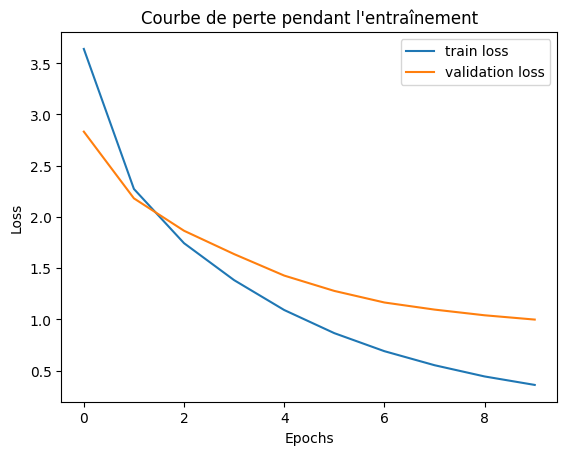

In [53]:
# Visualisation des courbes de perte
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Courbe de perte pendant l\'entraînement')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Affichage des légendes générées
Nous allons maintenant tester le modèle sur quelques images et afficher les légendes générées.

In [ ]:
# Fonction de génération de légende pour une image donnée
def generate_caption(model, tokenizer, image_features, max_length):
    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([image_features, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word[yhat]
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

# Génération de légendes pour des images
for i in range(5):  # Exemple avec 5 images
    caption = generate_caption(caption_model, tokenizer, test_features[i], max_length)
    print(f"Generated caption: {caption}")
